<a href="https://colab.research.google.com/github/ladrianx/proyectos/blob/main/arma_garch_stf_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programa en R para ajustar modelos ARMA y GARCH

In [ ]:
!pip install pandas numpy matplotlib yfinance statsmodels arch pmdarima

In [ ]:
!pip install missingpy
#!pip install --upgrade scikit-learn

## Definir la lista de acciones

In [ ]:
# Definir la lista de acciones
acciones = [
    ('GMEXICOB.MX', 'Grupo México'),
    #('BIMBOA.MX', 'Grupo Bimbo'),
    ('AMX', 'América Móvil'),
    #('TLEVISACPO.MX', 'Televisa'),
    #('CEMEXCPO.MX', 'Cemex'),
    #('ALFAA.MX', 'Grupo Alfa'),
    #('GFNORTEO.MX', 'Grupo Banorte'),
    #('SAN.MX', 'Santander México'),
    ('FEMSAUBD.MX', 'Femsa'),
    #('AC.MX', 'Arca Continental'),
    #('GAPB.MX', 'GA del Pacífico'),
    #('OMAB.MX', 'GA del Centro Norte'),
    #('ALSEA.MX', 'Alsea'),
    #('PE&OLES.MX', 'Peñoles'),
    ('^MXX', 'IPC'),
    ('MXN=X', 'FXUSD')#,
    #('FTBIVA.FGI', 'FTSE BIVA'),
    #('INMEX.MX', 'SPBMV INMEX'),
    #('IPCCOMPMX.MX', 'SPBMV IPC'),
    #('CNY=X', 'FXCNY'),
    #('NVDA', 'NVIDIA Corporation'),
    #('GC=F', 'GOLD 24DC'),
    #('CL=F', 'CRUDE OIL 24DC')
]

# Periodo de tiempo definido
inicio = '2024-01-01'
fin = '2024-12-22'#datetime.datetime.now().strftime('%Y-%m-%d')


## Importar las librerías necesarias

In [ ]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  # Para imputar valores faltantes

# Función para imputar datos faltantes y asegurar frecuencia diaria
def preparar_datos(ticker, inicio, fin):
    try:
        # Descargar datos
        data = yf.download(ticker, start=inicio, end=fin)

        # Asegurar que el índice sea de tipo datetime y con frecuencia diaria
        data.index = pd.to_datetime(data.index)
        #data = data.asfreq('D')  # Frecuencia diaria

        # Calcular retornos logarítmicos
        data['Return'] = 100 * np.log(data['Close'] / data['Close'].shift(1))

        # Imputar valores faltantes
        #if data.isnull().sum().sum() > 0:
         #   imputador = IterativeImputer(max_iter=10, random_state=42)
         #   data_imputado = imputador.fit_transform(data)
         #   data = pd.DataFrame(data_imputado, index=data.index, columns=data.columns)

        return data['Return'].dropna()

    except Exception as e:
        print(f"Error procesando datos para {ticker}: {e}")
        return None

## Función para graficar los datos

[*********************100%***********************]  1 of 1 completed


Procesando datos para: Grupo México


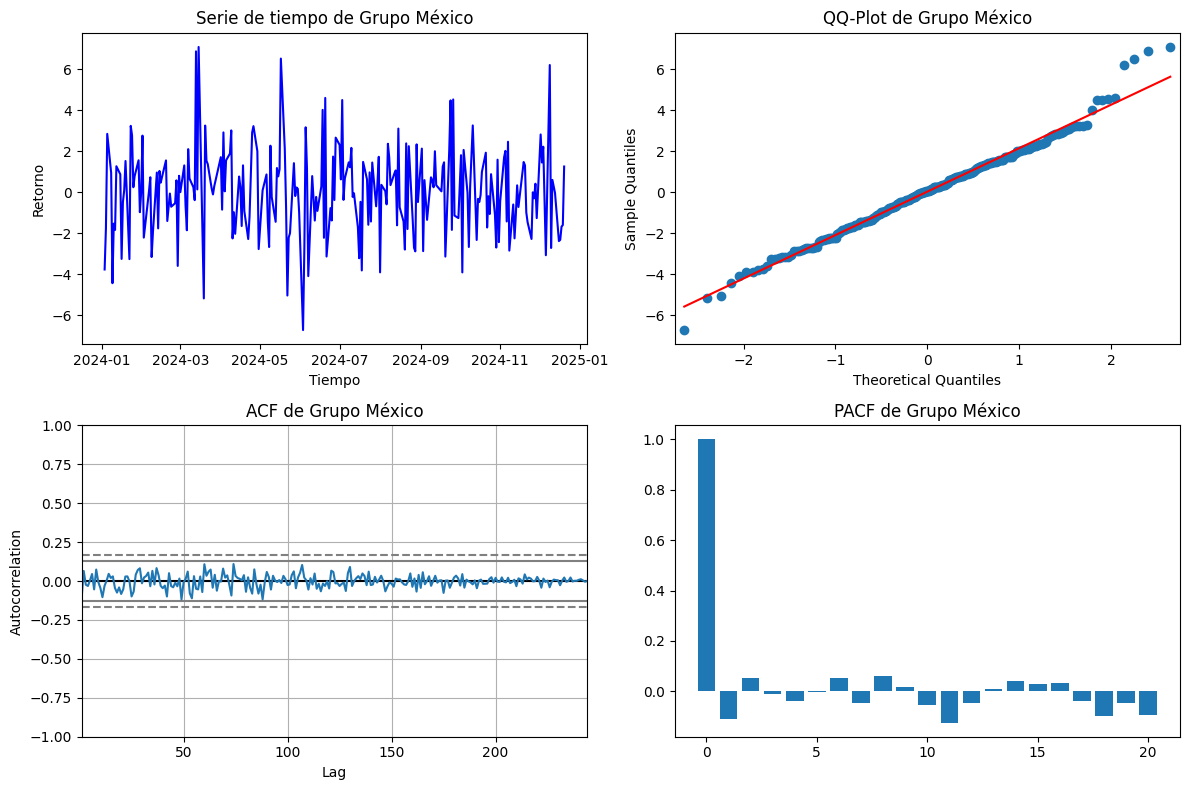

[*********************100%***********************]  1 of 1 completed


Procesando datos para: América Móvil


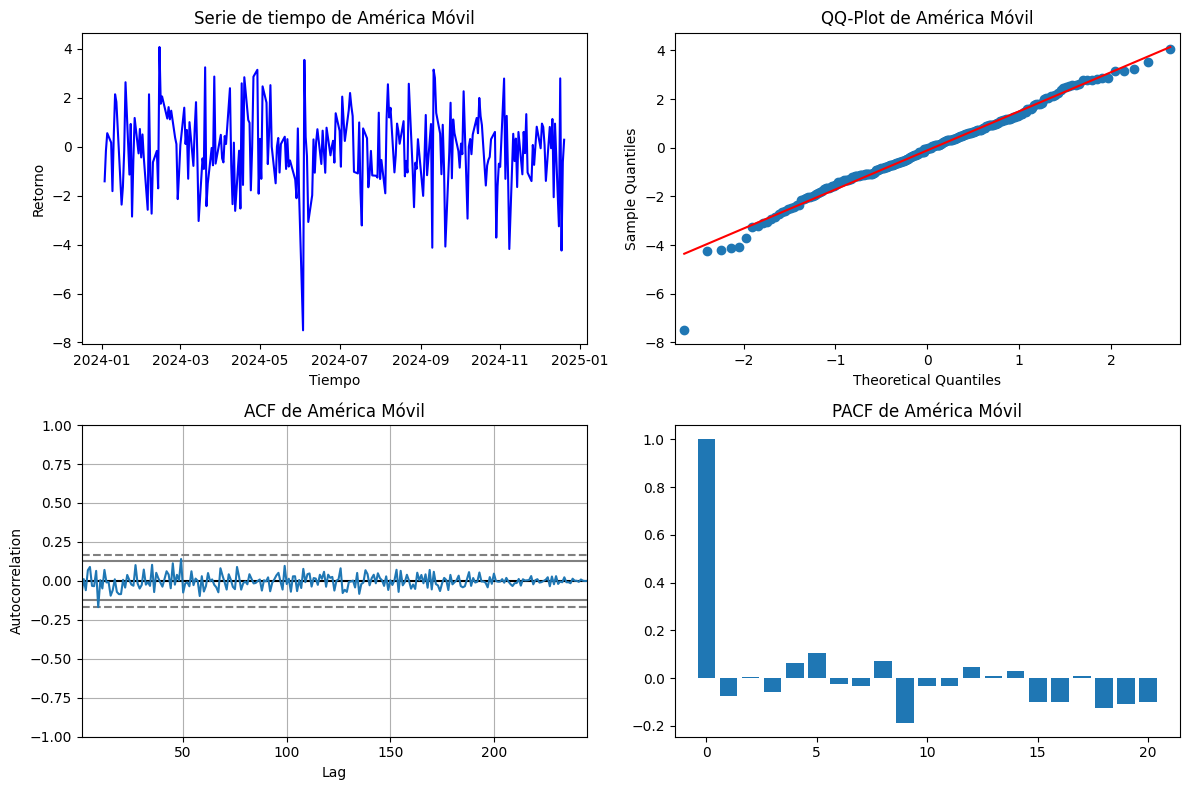

[*********************100%***********************]  1 of 1 completed


Procesando datos para: Femsa


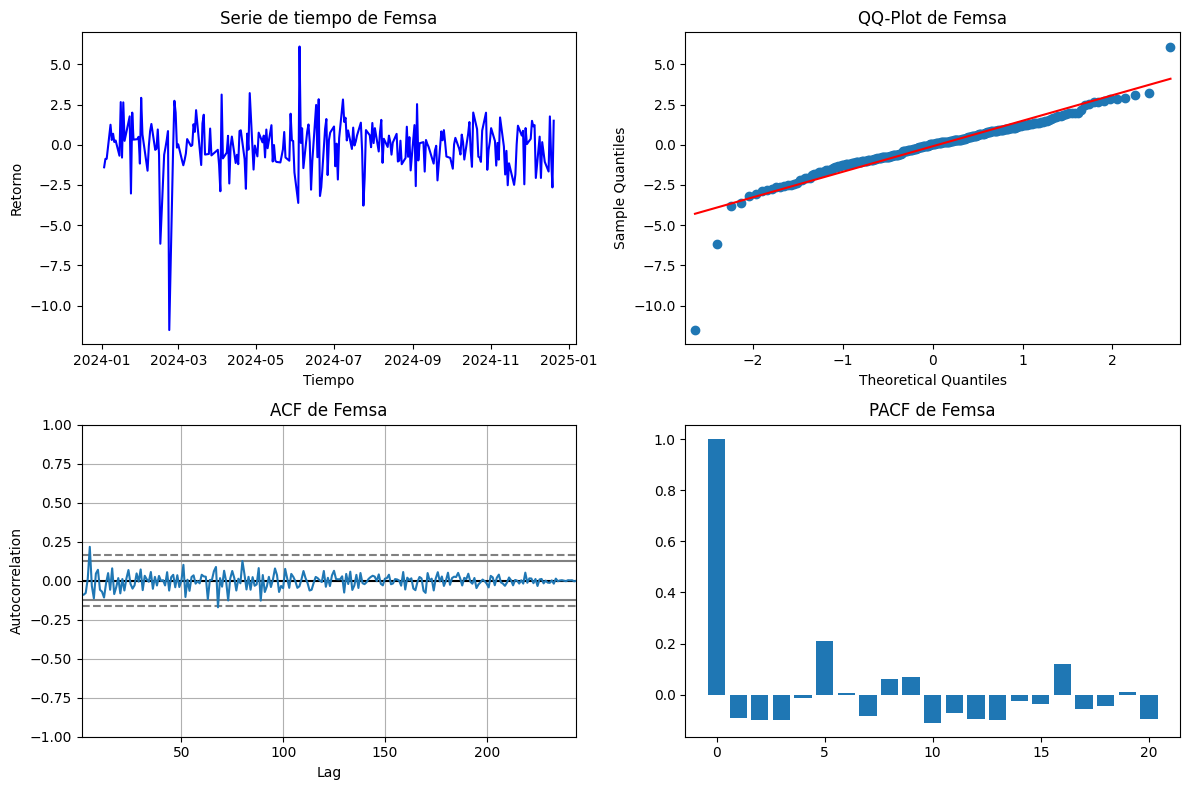

[*********************100%***********************]  1 of 1 completed


Procesando datos para: IPC


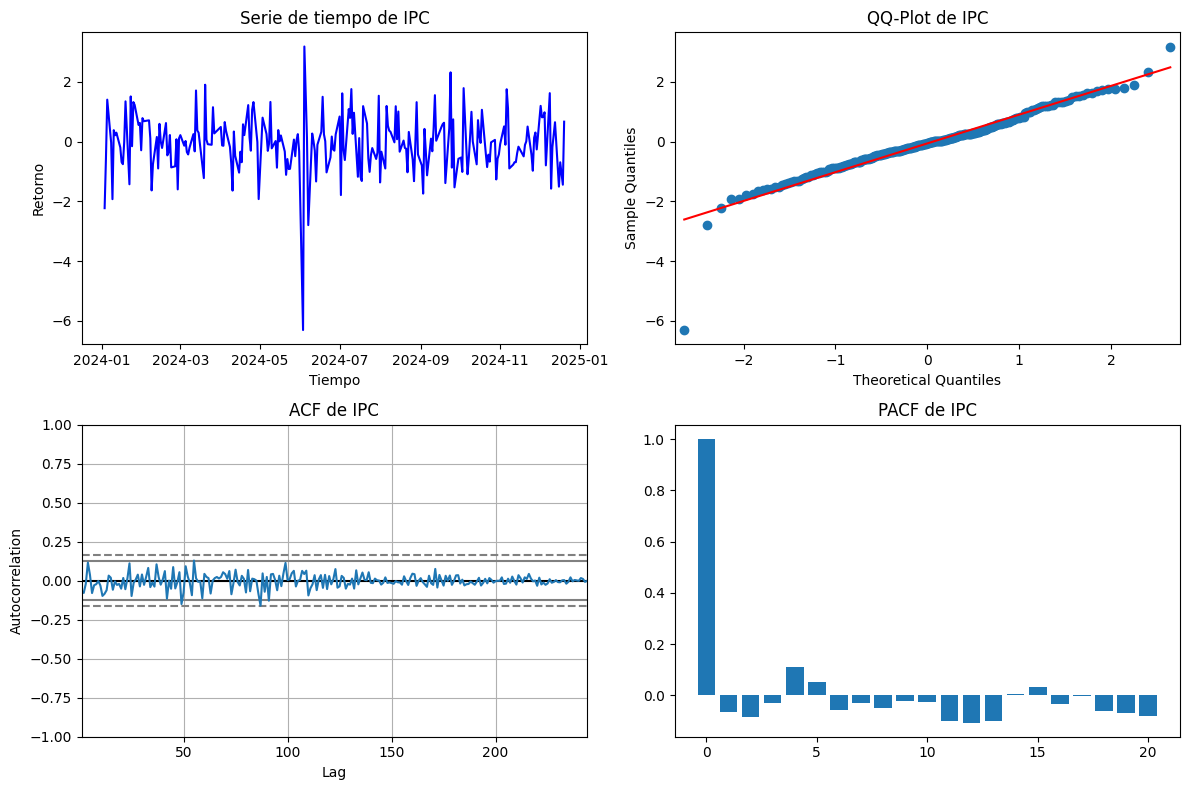

[*********************100%***********************]  1 of 1 completed


Procesando datos para: FXUSD


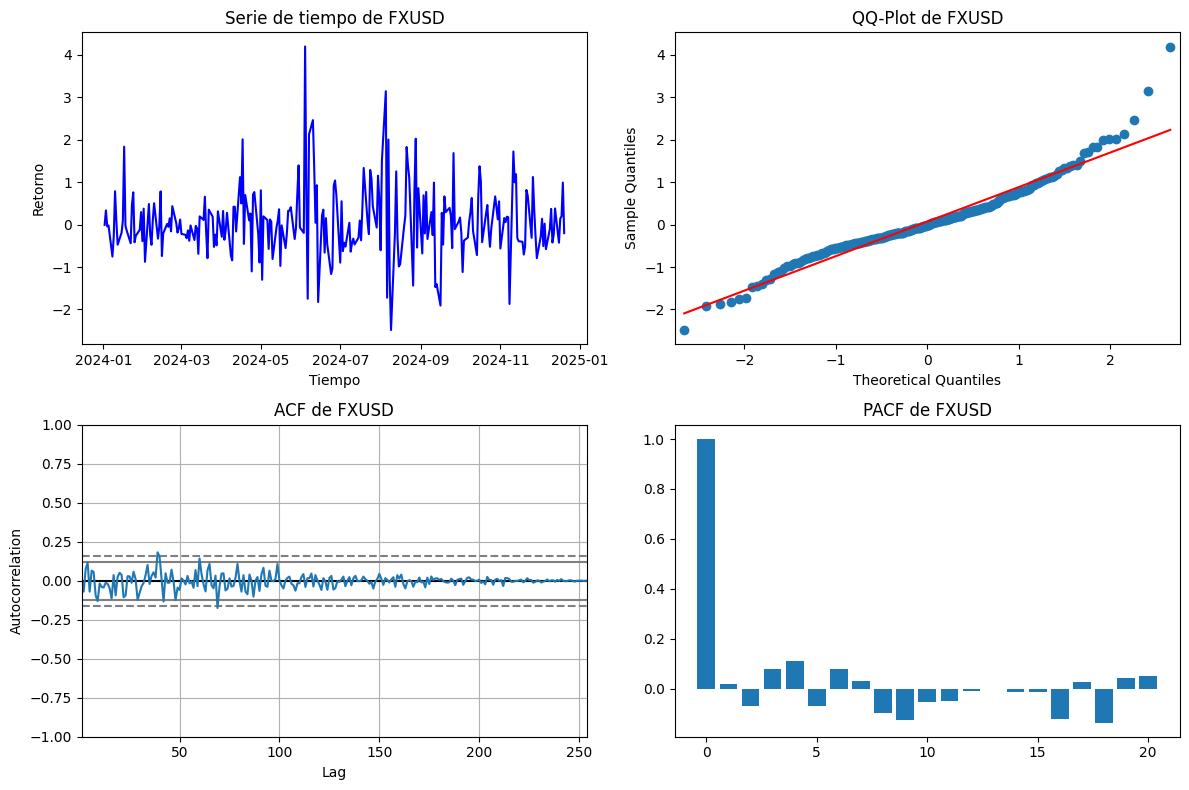

In [ ]:
# Función para graficar los datos
def graficar_datos(returns, nombre):
    plt.figure(figsize=(12, 8))

    # Gráfico de la serie de tiempo
    plt.subplot(2, 2, 1)
    plt.plot(returns, color='blue')
    plt.title(f'Serie de tiempo de {nombre}')
    plt.xlabel('Tiempo')
    plt.ylabel('Retorno')

    # QQ-Plot para evaluar la normalidad
    plt.subplot(2, 2, 2)
    qqplot(returns, line='s', ax=plt.gca())
    plt.title(f'QQ-Plot de {nombre}')

    # ACF
    plt.subplot(2, 2, 3)
    autocorrelation_plot(returns)
    plt.title(f'ACF de {nombre}')

    # PACF
    plt.subplot(2, 2, 4)
    pacf_vals = pacf(returns, nlags=20)
    plt.bar(range(len(pacf_vals)), pacf_vals)
    plt.title(f'PACF de {nombre}')

    plt.tight_layout()
    plt.show()

# Descargar los datos y generar los gráficos para cada acción
for ticker, nombre in acciones:
    print(f"\nProcesando datos para: {nombre}")
    returns = preparar_datos(ticker, inicio, fin)

    if returns is not None:
        graficar_datos(returns, nombre)
    else:
        print(f"No se pudieron procesar los datos para {nombre}.")

## Pruebas de estacionariedad e independencia

In [ ]:
# Importar bibliotecas adicionales necesarias
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  # Para imputar valores faltantes
import warnings

# Inicializar lista para almacenar resultados
resultados_pruebas = []

# Función para preparar los datos (frecuencia diaria y valores faltantes)
def preparar_datos(ticker, inicio, fin):
    try:
        # Descargar datos de Yahoo Finance
        data = yf.download(ticker, start=inicio, end=fin)

        if data.empty:
            raise ValueError(f"No se obtuvieron datos para {ticker}.")

        # Asegurarse de que el índice sea un DatetimeIndex y frecuencia diaria
        data.index = pd.to_datetime(data.index)
        #data = data.asfreq('D')

        # Calcular los retornos logarítmicos
        data['Return'] = 100 * np.log(data['Close'] / data['Close'].shift(1))

        # Imputar valores faltantes con IterativeImputer
        #if data.isnull().sum().sum() > 0:
         #   imputador = IterativeImputer(max_iter=10, random_state=42)
         #   datos_imputados = imputador.fit_transform(data)
         #   data = pd.DataFrame(datos_imputados, index=data.index, columns=data.columns)

        # Devolver la serie de retornos sin nulos
        return data['Return'].dropna()

    except Exception as e:
        print(f"Error procesando datos para {ticker}: {e}")
        return None

# Función para calcular y almacenar las pruebas de estacionariedad
def calcular_pruebas(returns, nombre):
    try:
        # Prueba de Dickey-Fuller
        adf_pvalue = adfuller(returns)[1]

        # Prueba KPSS con advertencias suprimidas
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            kpss_pvalue = kpss(returns, regression='c')[1]

        # Prueba de Box-Ljung
        box_ljung_pvalue = acorr_ljungbox(returns, lags=[10], return_df=True)['lb_pvalue'].iloc[0]

        # Almacenar resultados en la lista de diccionarios
        resultados_pruebas.append({
            'Accion': nombre,
            'ADF_P_Value': adf_pvalue,
            'KPSS_P_Value': kpss_pvalue,
            'Box_Ljung_P_Value': box_ljung_pvalue,
            'Estacionario_ADF': "Estacionario" if adf_pvalue < 0.05 else "No estacionario",
            'Estacionario_KPSS': "Estacionario" if kpss_pvalue > 0.05 else "No estacionario",
            'Estacionario_Box_Ljung': "Independiente" if box_ljung_pvalue > 0.05 else "No independiente"
        })
    except Exception as e:
        print(f"Error al calcular pruebas para {nombre}: {e}")


# Descargar los datos y realizar pruebas para cada acción
for ticker, nombre in acciones:
    try:
        #print(f"\nProcesando {nombre} ({ticker})...")
        returns = preparar_datos(ticker, inicio, fin)
        if returns is not None:
            calcular_pruebas(returns, nombre)
        else:
            print(f"No se generaron retornos para {nombre} ({ticker}).")
    except Exception as e:
        print(f"Error al procesar datos para {nombre}: {e}")

# Convertir resultados a DataFrame y mostrar
resultados_pruebas_df = pd.DataFrame(resultados_pruebas)
print("\nResultados de las pruebas de estacionariedad:")
resultados_pruebas_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Resultados de las pruebas de estacionariedad:


,Accion,ADF_P_Value,KPSS_P_Value,Box_Ljung_P_Value,Estacionario_ADF,Estacionario_KPSS,Estacionario_Box_Ljung
0,Grupo México,4.585632e-30,0.1,0.665704,Estacionario,Estacionario,Independiente
1,América Móvil,1.244585e-29,0.1,0.155006,Estacionario,Estacionario,Independiente
2,Femsa,6.771973e-08,0.1,0.008692,Estacionario,Estacionario,No independiente
3,IPC,1.375056e-29,0.1,0.576660,Estacionario,Estacionario,Independiente
4,FXUSD,2.139471e-28,0.1,0.086940,Estacionario,Estacionario,Independiente


## Predicciones

In [ ]:
import warnings
import pandas as pd
import numpy as np
import yfinance as yf
from pmdarima import auto_arima
from arch import arch_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer  # Para imputar valores faltantes

# Ignorar advertencias específicas de deprecación
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

# Función para calcular errores diarios
def calcular_errores_por_dia(real, pred):
    eab = np.abs(real - pred)      # Error absoluto
    ems = (real - pred) ** 2       # Error cuadrático
    rems = np.sqrt(ems)            # Raíz del error cuadrático
    return pd.DataFrame({'EAB': eab, 'EMS': ems, 'REMS': rems})

# Función para preparar los datos (frecuencia diaria y valores faltantes)
def preparar_datos(ticker, inicio, fin):
    try:
        # Descargar datos de Yahoo Finance
        data = yf.download(ticker, start=inicio, end=fin)

        if data.empty:
            raise ValueError(f"No se obtuvieron datos para {ticker}.")

        # Asegurarse de que el índice sea un DatetimeIndex y frecuencia diaria
        data.index = pd.to_datetime(data.index)
        #data = data.asfreq('D')

        # Calcular los retornos logarítmicos
        data['Return'] = 100 * np.log(data['Close'] / data['Close'].shift(1))

        # Imputar valores faltantes con IterativeImputer
        #if data.isnull().sum().sum() > 0:
         #   imputador = IterativeImputer(max_iter=10, random_state=42)
         #   datos_imputados = imputador.fit_transform(data)
         #   data = pd.DataFrame(datos_imputados, index=data.index, columns=data.columns)

        # Devolver la serie de retornos sin nulos
        return data['Return'].dropna()

    except Exception as e:
        print(f"Error procesando datos para {ticker}: {e}")
        return None

# Función para ajustar y evaluar modelos en una serie temporal
def ajustar_modelos_series_tiempo(serie_entrenamiento, serie_prueba, valores_reales):
    resultados = {}

    try:
        # Modelo ARMA
        print("\n Ajustando ARMA...")
        modelo_arma = auto_arima(serie_entrenamiento, start_p=1, start_q=1, max_p=3, max_q=3, seasonal=False, stationary=True)
        pred_arma = modelo_arma.predict(n_periods=len(serie_prueba))
        errores_arma = calcular_errores_por_dia(valores_reales, pred_arma)
        resultados['ARMA'] = {'Predicciones': pred_arma, 'Errores': errores_arma}
    except Exception as e:
        print(f"Error al ajustar ARMA: {e}")

    try:
        # Modelo GARCH
        print("\n Ajustando GARCH...")
        modelo_garch = arch_model(serie_entrenamiento, vol='Garch', p=1, q=1, dist='normal').fit(disp='off')
        pred_garch = modelo_garch.conditional_volatility[-len(serie_prueba):]
        errores_garch = calcular_errores_por_dia(valores_reales, pred_garch)
        resultados['GARCH'] = {'Predicciones': pred_garch, 'Errores': errores_garch}
    except Exception as e:
        print(f"Error al ajustar GARCH: {e}")

    return resultados

#Procesar datos para cada acción
resultados_globales = []
for ticker, nombre in acciones:
    print(f"\n\n Procesando datos para: {nombre} ({ticker})...")
    serie_retorno = preparar_datos(ticker, inicio, fin)

    if serie_retorno is not None:
        if len(serie_retorno) > 1:
            serie_entrenamiento = serie_retorno[:-1]
            serie_prueba = serie_retorno[-1:]
            valores_reales = serie_prueba.values

            resultados_modelos = ajustar_modelos_series_tiempo(serie_entrenamiento, serie_prueba, valores_reales)
            if resultados_modelos:
                for modelo, datos in resultados_modelos.items():
                    predicciones = datos['Predicciones']
                    errores = datos['Errores']
                    for i, pred in enumerate(predicciones):
                        resultados_globales.append({
                            'Accion': nombre,
                            'Modelo': modelo,
                            'Retorno Real': valores_reales[i],
                            'Predicción': pred,
                            'EAB': errores['EAB'].iloc[i],
                            'EMS': errores['EMS'].iloc[i],
                            'REMS': errores['REMS'].iloc[i]
                        })
        else:
            print(f"Datos insuficientes para: {nombre} ({ticker}).")
    else:
        print(f"Error al procesar datos para: {nombre} ({ticker}).")

# Crear DataFrame final con todos los resultados
if resultados_globales:
    tabla_resultados_final = pd.DataFrame(resultados_globales)
    #print(tabla_resultados_final)
else:
    print("No se generaron resultados.")
tabla_resultados_final


[*********************100%***********************]  1 of 1 completed




 Procesando datos para: Grupo México (GMEXICOB.MX)...

 Ajustando ARMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
[*********************100%***********************]  1 of 1 completed



 Ajustando GARCH...


 Procesando datos para: América Móvil (AMX)...

 Ajustando ARMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
[*********************100%***********************]  1 of 1 completed



 Ajustando GARCH...


 Procesando datos para: Femsa (FEMSAUBD.MX)...

 Ajustando ARMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
[*********************100%***********************]  1 of 1 completed



 Ajustando GARCH...


 Procesando datos para: IPC (^MXX)...

 Ajustando ARMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
[*********************100%***********************]  1 of 1 completed



 Ajustando GARCH...


 Procesando datos para: FXUSD (MXN=X)...

 Ajustando ARMA...

 Ajustando GARCH...


,Accion,Modelo,Retorno Real,Predicción,EAB,EMS,REMS
0,Grupo México,ARMA,1.249441,0.000000,1.249441,1.561102,1.249441
1,Grupo México,GARCH,1.249441,2.093268,0.843828,0.712045,0.843828
2,América Móvil,ARMA,0.281096,0.000000,0.281096,0.079015,0.281096
3,América Móvil,GARCH,0.281096,2.164063,1.882967,3.545564,1.882967
4,Femsa,ARMA,1.493725,0.000000,1.493725,2.231214,1.493725
5,Femsa,GARCH,1.493725,1.513190,0.019465,0.000379,0.019465
6,IPC,ARMA,0.671269,0.000000,0.671269,0.450602,0.671269
7,IPC,GARCH,0.671269,0.952367,0.281098,0.079016,0.281098
8,FXUSD,ARMA,-0.199962,0.000000,0.199962,0.039985,0.199962
9,FXUSD,GARCH,-0.199962,0.563340,0.763302,0.582630,0.763302


## Coeficientes

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from pmdarima import auto_arima
from arch import arch_model

# Definir la lista de acciones
acciones = [
    ('GMEXICOB.MX', 'Grupo México'),
    ('AMX', 'América Móvil'),
    ('FEMSAUBD.MX', 'Femsa'),
    ('^MXX', 'IPC'),
    ('MXN=X', 'FXUSD')
]

# Periodo de tiempo definido
inicio = '2024-01-01'
fin = '2024-12-22'

# Función para ajustar modelos en una serie temporal
def ajustar_modelos_series_tiempo(serie_entrenamiento):
    try:
        # Modelo ARMA
        print("\nAjustando ARMA...")
        modelo_arma = auto_arima(serie_entrenamiento, start_p=1, start_q=1, max_p=3, max_q=3, seasonal=False, stationary=True)
        print("\nCoeficientes del modelo ARMA:")
        print(modelo_arma.params())
    except Exception as e:
        print(f"Error al ajustar ARMA: {e}")

    try:
        # Modelo GARCH
        print("\nAjustando GARCH...")
        modelo_garch = arch_model(serie_entrenamiento, vol='Garch', p=1, q=1, dist='normal').fit(disp='off')
        print("\nCoeficientes del modelo GARCH:")
        print(modelo_garch.params)
    except Exception as e:
        print(f"Error al ajustar GARCH: {e}")

# Descargar datos y ajustar modelos para cada acción
for ticker, nombre in acciones:
    print(f"\nProcesando: {nombre} ({ticker})")
    try:
        # Descargar datos de Yahoo Finance
        datos = yf.download(ticker, start=inicio, end=fin)
        if datos.empty:
            print(f"No se encontraron datos para {nombre} ({ticker})")
            continue

        # Calcular retornos logarítmicos
        datos['Return'] = 100 * np.log(datos['Close'] / datos['Close'].shift(1))
        serie_retorno = datos['Return'].dropna()

        # Dividir en datos de entrenamiento (80%)
        train_size = int(len(serie_retorno) * 1)
        serie_entrenamiento = serie_retorno[:train_size]

        # Ajustar modelos y mostrar resultados
        ajustar_modelos_series_tiempo(serie_entrenamiento)

    except Exception as e:
        print(f"Error procesando {nombre} ({ticker}): {e}")


[*********************100%***********************]  1 of 1 completed


Procesando: Grupo México (GMEXICOB.MX)

Ajustando ARMA...

Coeficientes del modelo ARMA:
sigma2    4.48866
dtype: float64

Ajustando GARCH...



[*********************100%***********************]  1 of 1 completed


Coeficientes del modelo GARCH:
mu          0.014237
omega       2.112290
alpha[1]    0.069668
beta[1]     0.454957
Name: params, dtype: float64

Procesando: América Móvil (AMX)

Ajustando ARMA...



[*********************100%***********************]  1 of 1 completed


Coeficientes del modelo ARMA:
sigma2    2.588905
dtype: float64

Ajustando GARCH...

Coeficientes del modelo GARCH:
mu         -1.094061e-01
omega       2.199711e+00
alpha[1]    1.470167e-01
beta[1]     2.247233e-13
Name: params, dtype: float64

Procesando: Femsa (FEMSAUBD.MX)

Ajustando ARMA...



[*********************100%***********************]  1 of 1 completed


Coeficientes del modelo ARMA:
sigma2    2.529264
dtype: float64

Ajustando GARCH...

Coeficientes del modelo GARCH:
mu         -0.105910
omega       0.208306
alpha[1]    0.117084
beta[1]     0.818079
Name: params, dtype: float64

Procesando: IPC (^MXX)

Ajustando ARMA...



[*********************100%***********************]  1 of 1 completed


Coeficientes del modelo ARMA:
sigma2    0.930769
dtype: float64

Ajustando GARCH...

Coeficientes del modelo GARCH:
mu         -0.066826
omega       0.379436
alpha[1]    0.039344
beta[1]     0.539613
Name: params, dtype: float64

Procesando: FXUSD (MXN=X)

Ajustando ARMA...



Coeficientes del modelo ARMA:
sigma2    0.666521
dtype: float64

Ajustando GARCH...

Coeficientes del modelo GARCH:
mu         -0.003890
omega       0.079250
alpha[1]    0.199218
beta[1]     0.693764
Name: params, dtype: float64
